# Certification of Robustness using Zonotopes with DeepZ

In this notebook we will demonstrate the usage of certification using zonotopes within ART. With deterministic certification methods such as DeepZ we can have a guarantee if a datapoint could have its class changed under a given bound. This method was originally proposed in: https://papers.nips.cc/paper/2018/file/f2f446980d8e971ef3da97af089481c3-Paper.pdf

The zonotopes abstraction used here is defined by:
\begin{equation}
    \hat{x} = \eta_0 + \sum_{i=1}^{i=N} \eta_i \epsilon_i 
\end{equation}

where $\eta_0$ is the central vector, $\epsilon_i$ are noise symbols, $\eta_i$ are coefficients representing deviations around $\eta_0$.

We can illustrate a 2D toy example of this below in which the initial datapoint has two features, with a central vector of [0.25, 0.25] and these features both have noise terms of [0.25, 0.25]. We push this zonotope through the neural network and show it's intermediate shapes:


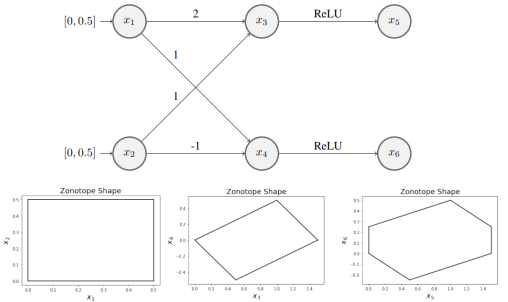

We can see that the zonotope changes shape as it is passed through the neural network. When passing though a ReLU it gains another term (going from 2 sets of parallel lines to 3). We can then check if the final zonotope crosses any desicion boundaries and say if a point is certified.

Let's see how to use this method in ART!

In [1]:
import torch
import torch.optim as optim
import numpy as np

from torch import nn
from sklearn.utils import shuffle

from art.estimators.certification import deep_z
from art.utils import load_mnist, preprocess, to_categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# We make an example pytorch classifier

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=(4, 4),
                               stride=(2, 2),
                               dilation=(1, 1),
                               padding=(0, 0))
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=(4, 4),
                               stride=(2, 2),
                               dilation=(1, 1),
                               padding=(0, 0))
        self.fc1 = nn.Linear(in_features=800,
                             out_features=10)
        self.relu = nn.ReLU()

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [3]:
model = MNISTModel()
opt = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_test = np.squeeze(x_test)
x_test = np.expand_dims(x_test, axis=1)
y_test = np.argmax(y_test, axis=1)

x_train = np.squeeze(x_train)
x_train = np.expand_dims(x_train, axis=1)
y_train = np.argmax(y_train, axis=1)

In [4]:
# train the model normally

def standard_train(model, opt, criterion, x, y, bsize=32, epochs=5):
    num_of_batches = int(len(x) / bsize)
    for epoch in range(epochs):
        x, y = shuffle(x, y)
        loss_list = []
        for bnum in range(num_of_batches):
            x_batch = np.copy(x[bnum * bsize:(bnum + 1) * bsize])
            y_batch = np.copy(y[bnum * bsize:(bnum + 1) * bsize])

            x_batch = torch.from_numpy(x_batch).float().to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)

            # zero the parameter gradients
            opt.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_list.append(loss.data)
            loss.backward()
            opt.step()
        print('End of epoch {} loss {}'.format(epoch, np.mean(loss_list)))
    return model

model = standard_train(model=model,
                       opt=opt,
                       criterion=criterion,
                       x=x_train,
                       y=y_train)


End of epoch 0 loss 0.5815373063087463
End of epoch 1 loss 0.2648811340332031
End of epoch 2 loss 0.18593080341815948
End of epoch 3 loss 0.1360677033662796
End of epoch 4 loss 0.10795646160840988


In [5]:
# lets now get the predicions for the MNIST test set and see how well our model is doing.
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)

Test acc:  97.46000000000001


In [6]:
# But how robust are these predictions? 
# We can now examine this neural network's certified robustness. 
# We pass it into PytorchDeepZ. We will get a print out showing which 
# neural network layers have been registered. There will also be a 
# warning to tell us that PytorchDeepZ currently infers a reshape when 
# a neural network goes from using convolutional to dense layers. 
# This will cover the majority of use cases, however, if not then the 
# certification layers in art.estimators.certification.deepz.deep_z.py 
# can be used to directly build a certified model structure.

zonotope_model = deep_z.PytorchDeepZ(model=model, 
                                     clip_values=(0, 1), 
                                     loss=nn.CrossEntropyLoss(), 
                                     input_shape=(1, 28, 28), 
                                     nb_classes=10)

registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
Inferred reshape on op num 4


/home/giulio/Documents/Projects/AI2_for_ART/adversarial-robustness-toolbox/art/estimators/certification/deep_z/pytorch.py:90: UserWarning: 
This estimator does not support networks which have dense layers before convolutional. We currently infer a reshape when a neural network goes from convolutional layers to dense layers. If your use case does not fall into this pattern then consider directly building a certifier network with the custom layers found in art.estimators.certification.deepz.deep_z.py

  "\nThis estimator does not support networks which have dense layers before convolutional. "


In [7]:
# Lets now see how robust our model is!
# First we need to define what bound we need to check. 
# Here let's check for L infinity robustness with small bound of 0.05

bound = 0.05
num_certified = 0
num_correct = 0

# lets now loop over the data to check its certified robustness:
# we need to consider a single sample at a time as due to memory and compute footprints batching is not supported.
# In this demo we will look at the first 50 samples of the MNIST test data.
original_x = np.copy(x_test)
for i, (sample, pred, label) in enumerate(zip(x_test[:50], test_preds[:50], y_test[:50])):
    
    # we make the matrix representing the allowable perturbations. 
    # we have 28*28 features and each one can be manipulated independently requiring a different row.
    # hence a 784*784 matrix.
    eps_bound = np.eye(784) * bound
    
    # we then need to adjust the raw data with the eps bounds to take into account
    # the allowable range of 0 - 1 for pixel data.
    # We provide a simple function to do this preprocessing for image data.
    # However if your use case is not supported then a custom pre-processor function will need to be written.
    sample, eps_bound = zonotope_model.pre_process(cent=sample, 
                                                   eps=eps_bound)
    sample = np.expand_dims(sample, axis=0)

    # We pass the data sample and the eps bound to the certifier along with the prediction that was made
    # for the datapoint. 
    # A boolean is returned signifying if it can have its class changed under the given bound.
    is_certified = zonotope_model.certify(cent=sample,
                                          eps=eps_bound,
                                          prediction=pred)
    
    if pred == label:
        num_correct +=1
        if is_certified:
            num_certified +=1 
    
    print('Classified Correct {}/{} and also certified {}/{}'.format(num_correct, i+1, num_certified, i+1))


Classified Correct 1/1 and also certified 1/1
Classified Correct 2/2 and also certified 2/2
Classified Correct 3/3 and also certified 2/3
Classified Correct 4/4 and also certified 3/4
Classified Correct 5/5 and also certified 4/5
Classified Correct 6/6 and also certified 4/6
Classified Correct 7/7 and also certified 4/7
Classified Correct 8/8 and also certified 4/8
Classified Correct 9/9 and also certified 4/9
Classified Correct 10/10 and also certified 4/10
Classified Correct 11/11 and also certified 5/11
Classified Correct 12/12 and also certified 6/12
Classified Correct 13/13 and also certified 7/13
Classified Correct 14/14 and also certified 8/14
Classified Correct 15/15 and also certified 9/15
Classified Correct 16/16 and also certified 10/16
Classified Correct 17/17 and also certified 11/17
Classified Correct 18/18 and also certified 12/18
Classified Correct 19/19 and also certified 12/19
Classified Correct 20/20 and also certified 13/20
Classified Correct 21/21 and also certifie

In [8]:
# we can then compare this to the empirical PGD performance

from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=opt,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

attack = ProjectedGradientDescent(classifier, eps=0.05, eps_step=0.01, verbose=False)
x_train_adv = attack.generate(x_test[:50].astype('float32'))
y_adv_pred = classifier.predict(torch.from_numpy(x_train_adv).float().to(device))
y_adv_pred = np.argmax(y_adv_pred, axis=1)
print('Test acc: ', np.mean(y_adv_pred == y_test[:50]) * 100)

Test acc:  92.0


we can see that the empirical test accuracy is much higher than the certifiable performance. This is because with certifiable techniques we will be providing a lower bound on the performance: there may well be datapoints that the certifier says are unsafe, but in fact cannot have their class changed.